## Load all the scripts
Here, all the modules are called using the _import-ipynb_ librairy. To install, use command :
``` python
!pip install import-ipynb 
```

This imports all the functions to this notebook

In [1]:
#load all the functions from other scripts
import import_ipynb
%run IP/IP_methods.ipynb #Image processing script
%run PathPlanning.ipynb
%run localisation.ipynb
%run local_navigation_final.ipynb
%run follow_road.py
%run path_following.ipynb

You should consider upgrading via the 'C:\Users\franc\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\franc\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


# __1) Vision__
Here are called all the function related to the vision of this project.
## Constants and parameters

In [36]:
#folder name where the generated files will be stored
Path_to_MAP = 'output'

#whether to plot the vision outputs or not
plot_vis = True

## Call to functions
Here, only one top level function is needed. The image and the needed to be put in correct places. The start position and angle are returned as variables for easy access throughout the code

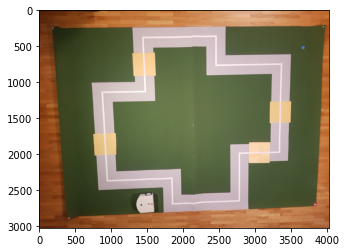

starting trimming img


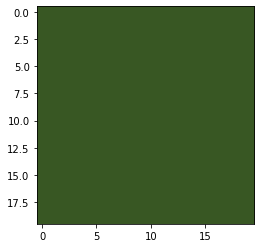

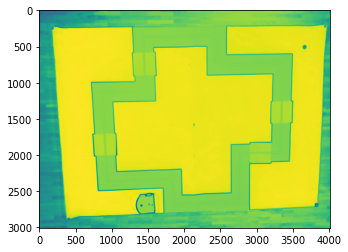

Trim finished


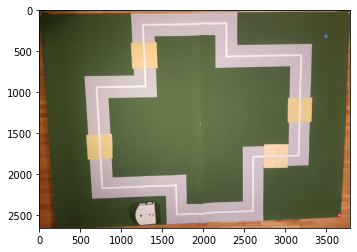

start finding thymio


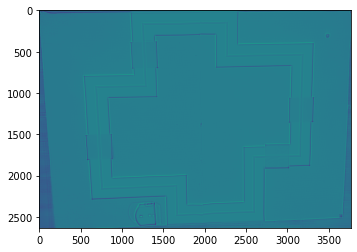

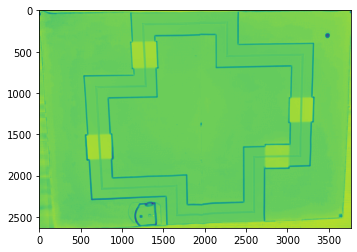

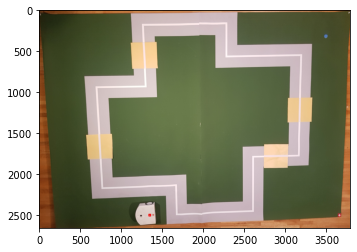

finished finding thymio
start detecting target position


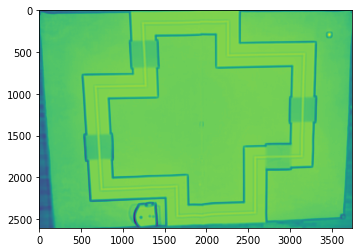

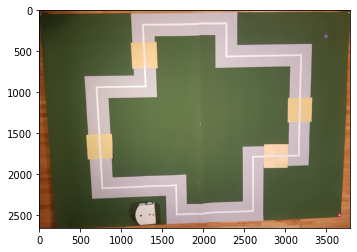

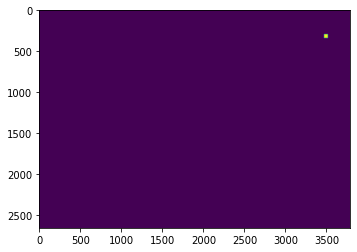

finish detecting target


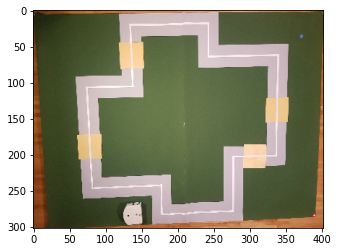

start detecting edge roads


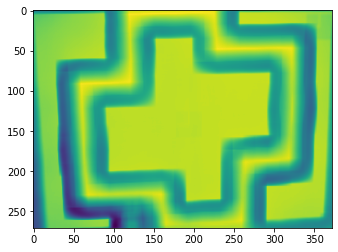

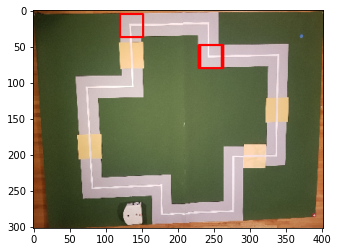

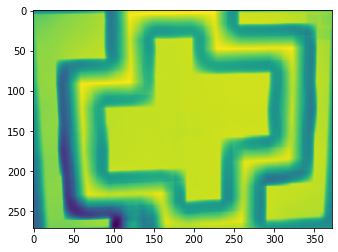

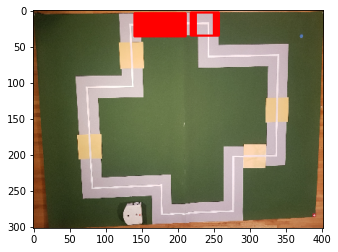

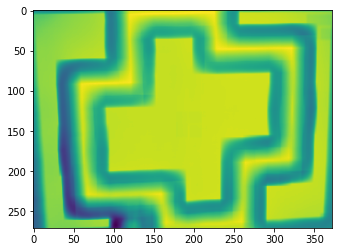

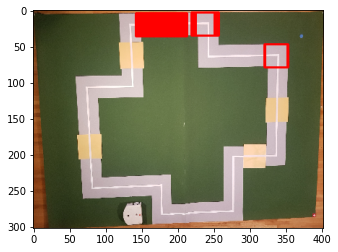

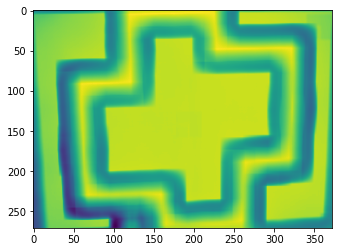

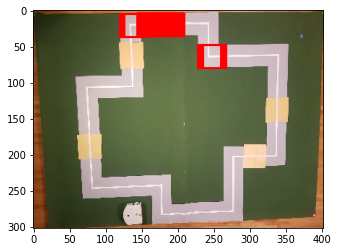

start detecting straigth roads


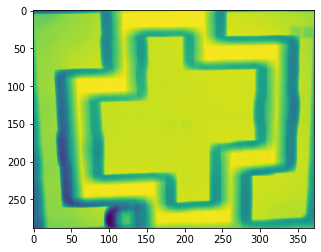

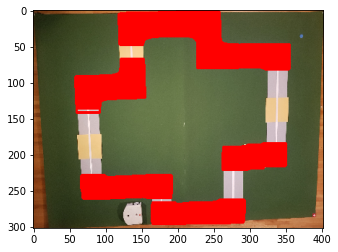

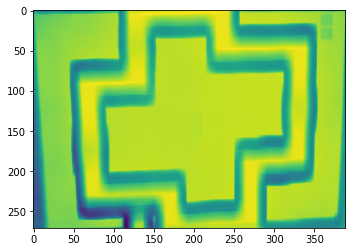

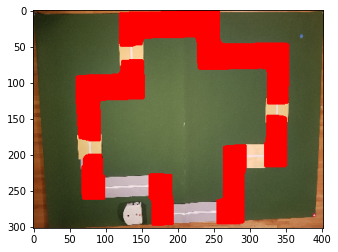

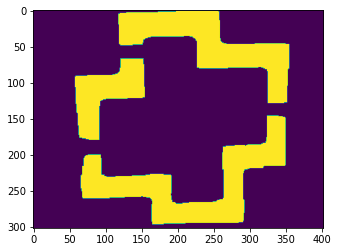

finish detecting roads
start detecting crossroads


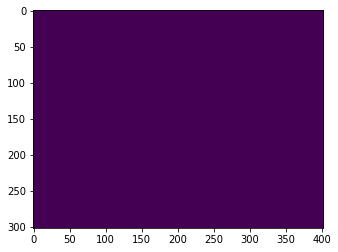

finish detecting cross roads


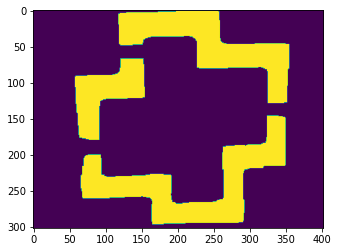

Image Processing finished in 23.901552438735962 seconds 


In [43]:
(x,y), orientation = pipeline_IP(plot_vis)
start = [x,y]

# __2) Path Planning__
## Constants and variables
The constants are named in all caps for easy identification. They should never change during the code.

In [74]:
#thymio radius 95 mm between the wheels
RADIUS = 40

#A0 size 841 x 1188 mm
XSIZE = 2*841
YSIZE = 1188
DESIRED_SIZE=[XSIZE, YSIZE]

CORR_FACT = 35

# Variables
epsilon_path_plan =  2000 # If the thymio chooses to exit the map, increase
smoothing_factor= 0.01 # smoothing factor, smaller is more smooth
csvPath = Path_to_MAP + "/obst.csv"
savePath = Path_to_MAP + "/csvIM.png"

goalPath = Path_to_MAP + "/goal.csv"
goalsavePath = Path_to_MAP + "/csvIM_goal.png"

graph_name = Path_to_MAP + '/graph'

plot_pp = True
verbose_pp = False

## Call to functions
The offline part is only called at the start to build the vision graph. Here the online part is also called, but can be called again during the rest of the code with a new starting position.

100%|██████████| 4/4 [00:00<00:00, 69.96it/s]


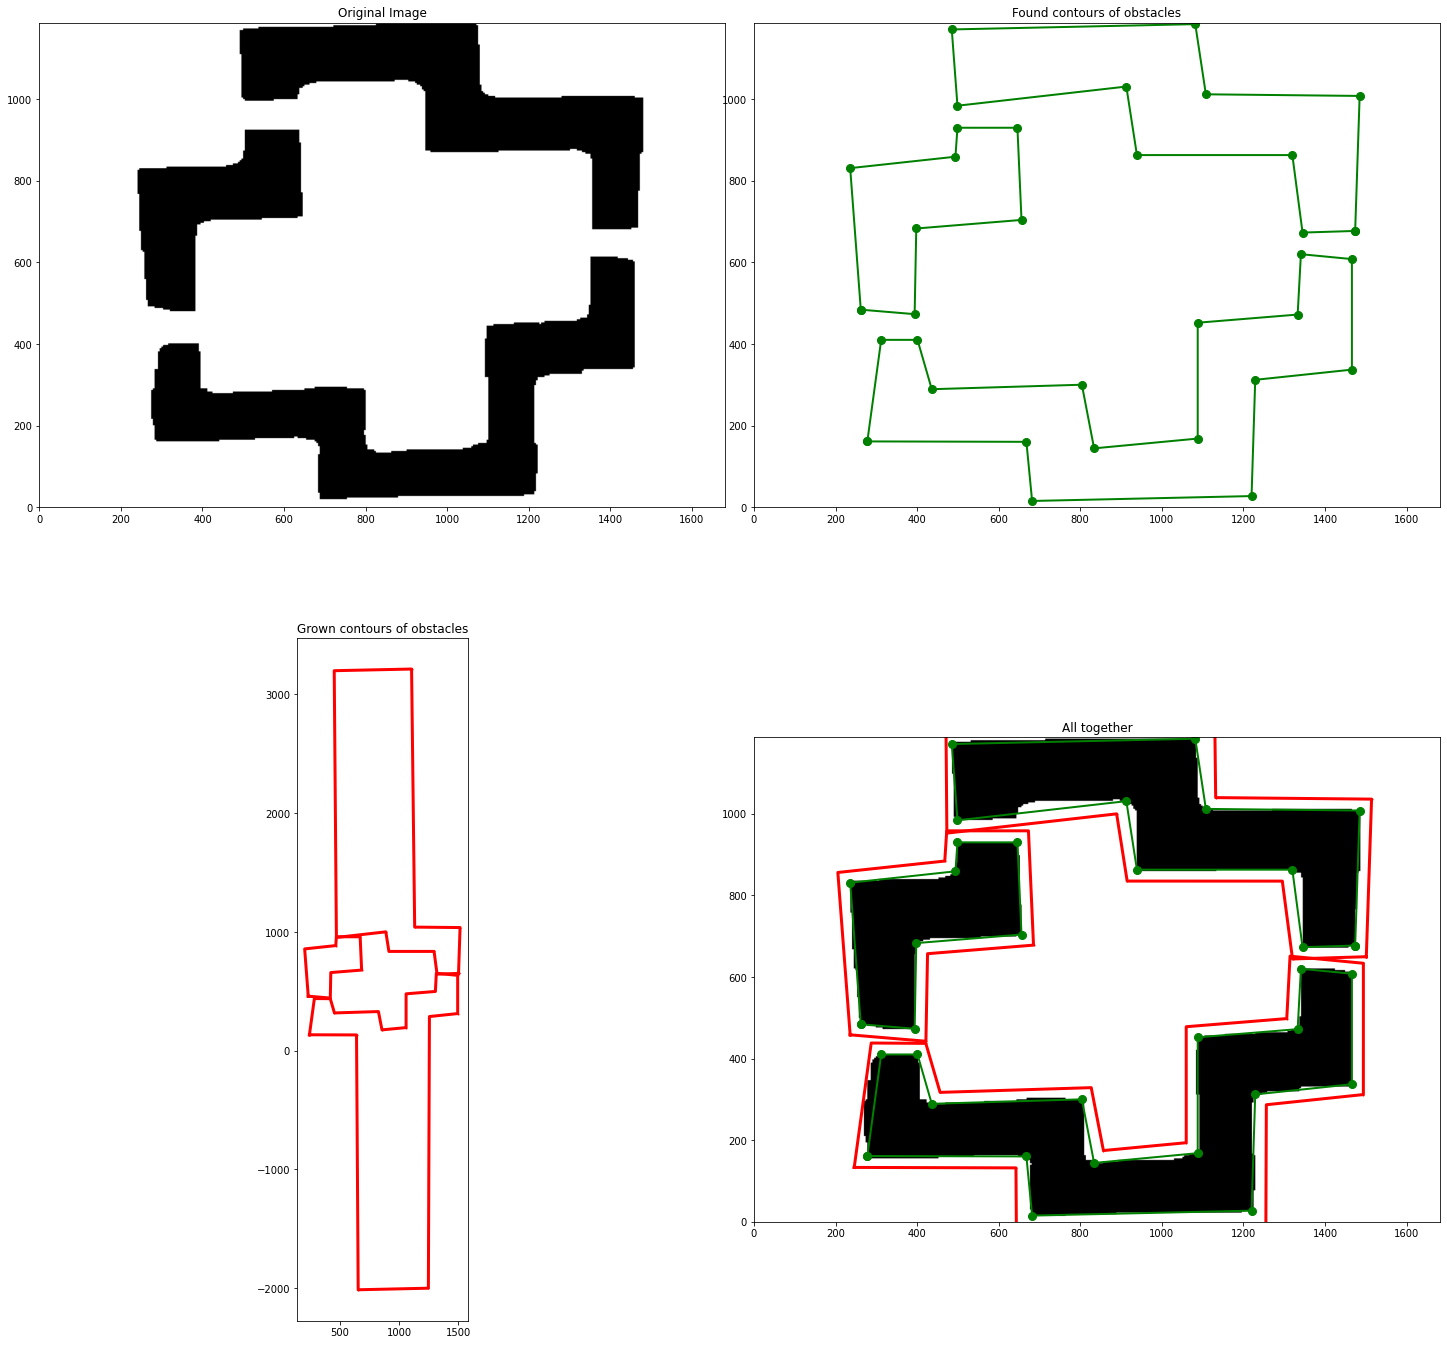

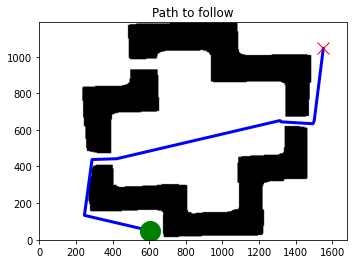

In [75]:
start = [143, 17]
[xs, ys] = np.genfromtxt(csvPath, delimiter=',').shape
startx = (start[0]-CORR_FACT)*XSIZE/(xs)
starty = start[1]*YSIZE/ys
start = [startx, starty]
goal = PathPlanning_offline(graph_name, csvPath, savePath, goalPath, goalsavePath, DESIRED_SIZE, 
                         smoothing_factor, RADIUS, epsilon_path_plan, plot_pp, verbose_pp)
path, inObstacle = PathPlanning_online(graph_name, start, goal, savePath, RADIUS, plot_pp, verbose_pp)

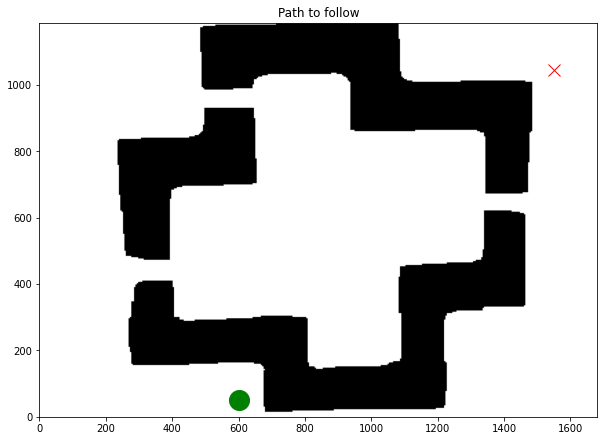

In [72]:
img = cv2.imread(savePath)
fig = plt.figure(figsize=(10,10))
plt.title("Path to follow")
plt.imshow(img, aspect = 'equal',origin = 'lower')
plt.plot(start[0], start[1], color = 'green', markersize=RADIUS/2 ,marker='o')
plt.plot(goal[0], goal[1], color = 'red', markersize=12 ,marker='x')

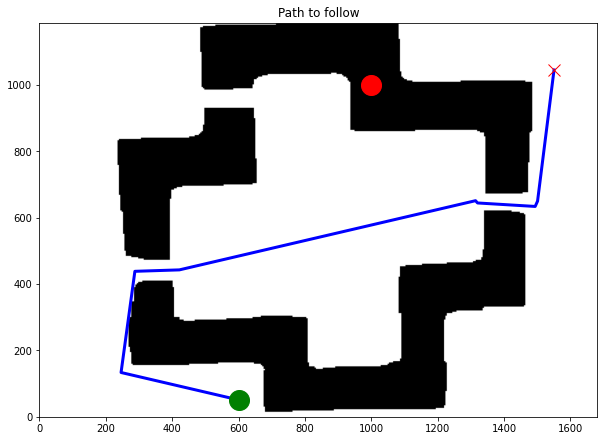

In [86]:
fig = plt.figure(figsize=(10,10))
_ ,_ = PathPlanning_online(graph_name, start, goal, savePath, RADIUS, True)
plt.plot(1000,1000, color = 'red', markersize=RADIUS/2 ,marker='o')
plt.show()

# Main loop of the algorithm 
In this loop is the state machine that runs the algorithm

In [ ]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [ ]:
#putting everything together
#putting together functions
obstacle = False
motor_left_target = 0
motor_right_target = 0
ITER_PATH_FREE = 9 #number of iteration where the path to the goal is free before we stop following the obstacle
dist_thresh = 20
#States of the robot
STATE_GLOBAL_NAV = 0
STATE_LOCAL_NAV = 1

#Threshold for obstacle detection
THRESHOLD_PROX1 = 1700
THRESHOLD_PROX2 = 1500
THRESHOLD_PROX3 = 1500
THRESHOLD_PROX0 = 2000
THRESHOLD_PROX4 = 2000

#refresh period
dt = 0.1

#initliasie the pose of the robot
pose = Pose(52, 260,math.pi/2,nb_particles = 150)
#pose.set_coords(500, 500, math.pi/2)

robot_state = STATE_GLOBAL_NAV

#objective
goals = path
coords = pose.get_coords()


#initialize variable for the loop
go_left = True
reset_glob_regulator = True
reset_local_regulator = True
speeds_robot = [0, 0]
obstacle = False
#plot_counter = 0

#counters used to determine if we must reset the PID controllers (integrator terms and derivatives)
local_nav_iter = 1
global_nav_iter = 1
#for local navigation counts how many consecutive iteration the path is free (used to go back to global nav)
free_path_iter = 0 
pose.plot(plot_theta = False)
goal_idx = 0
goal = goals[goal_idx]

dist_to_goal = math.sqrt((coords['x']-goal[0])**2+(coords['y']-goal[1])**2)
while dist_to_goal > dist_thresh and goal_idx <= len(goals)-1:
    print(goal)
    
    if dist_to_goal<dist_thresh*2:
        goal_idx+=1
        print("idx")
        print(goal_idx)
        if goal_idx <= len(goals)-1:
            goal = goals[goal_idx]
        
    
    if robot_state == STATE_GLOBAL_NAV:
        
        
        if global_nav_iter > 1:
            reset_glob_regulator = False
        else:
            print("GLOBAL")
            leds_circle[3] = 25
            leds_circle[1] = 0
            leds_circle[2] = 0

        global_nav_iter += 1
        
        prox = prox_horizontal
    
        obstacle = obstacle or obstacle_detected(prox[2], THRESHOLD_PROX2)
        obstacle = obstacle or obstacle_detected(prox[1], THRESHOLD_PROX1)
        obstacle = obstacle or obstacle_detected(prox[3], THRESHOLD_PROX3)
        obstacle = obstacle or obstacle_detected(prox[0], THRESHOLD_PROX0)
        obstacle = obstacle or obstacle_detected(prox[4], THRESHOLD_PROX4)
        if obstacle:
            leds_circle[2] = 25
        
        
        speed_theta = angle_PI([coords['x'],coords['y']], coords['theta'], goal, reset_glob_regulator)
        speed_disp = distance_PI([coords['x'],coords['y']], coords['theta'], goal, reset_glob_regulator)
        speeds_robot = [speed_theta+speed_disp,speed_disp-speed_theta]
        #speeds_robot = follow_path([coords['x'],coords['y'],coords['theta']],goal,reset_glob_regulator,dt) #[speed_theta+speed_disp,speed_disp-speed_theta]
        #follow_path([coords['x'],coords['y'],coords['theta']],goal,reset_glob_regulator,dt) #[speed_disp+speed_theta, speed_disp-speed_theta]
        
        if obstacle:
            robot_state = STATE_LOCAL_NAV
            coords = pose.get_coords()
            Go_left = choose_direction(prox, goal, (coords['x'],coords['y']), coords['theta'])
            #print("Go_left")
            #print(Go_left)
            print("IN OBSTCLE")
            reset_local_regulator = True
            local_nav_iter = 1
            free_path_iter = 0
            
            
    elif robot_state == STATE_LOCAL_NAV:
        
        prox = prox_horizontal
        
        if local_nav_iter > 1:
            reset_local_regulator = False
        else:
            print("LOCAL")
            leds_circle[3] = 0
            leds_circle[1] = 25

            
        local_nav_iter += 1
        
        if Go_left:
        #if turn left obstacle is on the rigth
            speeds = right_obst_follow(reset_local_regulator)
            speeds_robot = [speeds[1], speeds[0]]
        
        
        else:
            speeds = left_obst_follow(reset_local_regulator)
            speeds_robot = [speeds[1], speeds[0]]
    
  
        coords = pose.get_coords()
    
        if path_to_goal_free(coords['theta'], (coords['x'],coords['y']), goal ,prox):
            free_path_iter += 1
            print("free path iter")
            print(free_path_iter)
            if free_path_iter > ITER_PATH_FREE:
                    robot_state = STATE_GLOBAL_NAV
                    print("PATH IS FREE")
                    global_nav_iter = 1
                    reset_glob_regulator = True
                    obstacle = False
                    
                    
        else:
            free_path_iter = 0
        
    
    motor_left_target = speeds_robot[0]
    motor_right_target = speeds_robot[1]
    
  
    sleep(dt)
    speeds_meas = [motor_left_speed,motor_right_speed]    
    prox_grnd = prox_ground_delta
    pose.update(speed=speeds_meas, prox=prox_grnd, dt=dt, myMap = myMap)
    
    coords = pose.get_coords()
    dist_to_goal = math.sqrt((coords['x']-goal[0])**2+(coords['y']-goal[1])**2)
    if dist_to_goal < dist_thresh and goal_idx >= len(goals):
        break
    
    
    #if plot_counter == 8:
     #   plot_counter = 0
      #  pose.plot(plot_theta = False)
    #plot_counter += 1

sleep(dt)
motor_left_target = 0
motor_right_target = 0
pose.plot()
